In [1]:
from time import time
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import jax
import jax.tree_util as jtu
import jax.numpy as jnp

import pandas as pd

from functools import partial

import matplotlib.pyplot as plt

import optax

from base import loss_fn, predict_fn, get_params
from utils import train_fn, latexify
from data import generate_heinonen_gp_data

jax.config.update("jax_enable_x64", True)

%reload_ext watermark

# Config

In [2]:
gen_flex_dict = {"ell": 1, "sigma": 1, "omega": 1}
model_flex_dict = {"ell": 1, "sigma": 1, "omega": 1}
latent_seed = 200
latent_key = jax.random.PRNGKey(latent_seed)
data_seed = 300
data_key = jax.random.PRNGKey(data_seed)
default_params = False
n_points_list = [200, 400, 600, 800, 1000]

# Run

In [3]:
train_results = {"heinonen": [], "delta_inducing": []}
pred_results = {"heinonen": [], "delta_inducing": []}
for n_points in n_points_list:
    X_key = jax.random.PRNGKey(0)
    X = jax.random.uniform(X_key, shape=(n_points, 1), minval=-3, maxval=3).sort(axis=0)
    y, y_clean, ell, sigma, omega = generate_heinonen_gp_data(
        X, latent_key, data_key, gen_flex_dict
    )

    # Normalize
    # x_scaler = MinMaxScaler()
    # X = x_scaler.fit_transform(X)
    # xscale = x_scaler.data_max_ - x_scaler.data_min_
    yscale = jnp.max(jnp.abs(y - jnp.mean(y)))
    ymean = jnp.mean(y)
    y = (y - ymean) / yscale

    X_test = jnp.linspace(-4, 4, n_points*2).reshape(-1, 1)

    for method in ["heinonen", "delta_inducing"]:
        # Setup
        value_and_grad_fn = partial(loss_fn, X=X, y=y, flex_dict=model_flex_dict, method=method)
        partial_get_params = partial(
            get_params, X=X, flex_dict=model_flex_dict, method=method, default=default_params
        )
        params = jax.vmap(partial_get_params)(jax.random.split(jax.random.PRNGKey(1000), 10))
        partial_train_fn = partial(
            train_fn, loss_fn=value_and_grad_fn, optimizer=optax.adam(0.001), n_iters=5000
        )

        value_and_grad_fn(jtu.tree_map(lambda x: x[0], params)) # Warmup
        
        # Train
        train_init = time()
        results = jax.vmap(partial_train_fn)(init_raw_params=params)
        train_results[method].append(time() - train_init)
        
        best_idx = jnp.nanargmin(results["loss_history"][:, -1])
        result = jtu.tree_map(lambda x: x[best_idx], results)

        # Predict
        pred_init = time()
        pred_mean, pred_var, pred_ell, pred_sigma, pred_omega = predict_fn(
            result["raw_params"],
            X,
            y,
            X_test,
            model_flex_dict,
            method,
        )
        pred_results[method].append(time() - pred_init)
        
        print(f"{n_points}_{method} train: {train_results[method][-1]:.2f}")
        print(f"{n_points}_{method} pred: {pred_results[method][-1]:.2f}")

pd.to_pickle(train_results, "results/train_results.pkl")
pd.to_pickle(pred_results, "results/pred_results.pkl")

200_heinonen train: 20.19
200_heinonen pred: 3.75
200_delta_inducing train: 13.08
200_delta_inducing pred: 0.96
400_heinonen train: 39.79
400_heinonen pred: 3.57
400_delta_inducing train: 21.84
400_delta_inducing pred: 0.88
600_heinonen train: 68.83
600_heinonen pred: 3.73
600_delta_inducing train: 35.90
600_delta_inducing pred: 1.08
800_heinonen train: 103.27
800_heinonen pred: 2.64
800_delta_inducing train: 52.13
800_delta_inducing pred: 0.99
1000_heinonen train: 148.45
1000_heinonen pred: 3.70
1000_delta_inducing train: 74.13
1000_delta_inducing pred: 0.90


# Plot

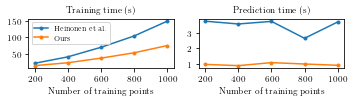

In [7]:
train_results = pd.read_pickle("results/train_results.pkl")
pred_results = pd.read_pickle("results/pred_results.pkl")

latexify(fig_width=5, fig_height=1.5)

fig, ax = plt.subplots(1, 2)

ax[0].plot(n_points_list, train_results["heinonen"], "-o", label="Heinonen et al.", markersize=3)
ax[0].plot(n_points_list, train_results["delta_inducing"], "-o", label="Ours", markersize=3)
ax[0].legend()
ax[0].set_xlabel("Number of training points")
ax[0].set_title("Training time (s)")

ax[1].set_title("Prediction time (s)")
ax[1].set_xlabel("Number of training points")
ax[1].plot(n_points_list, pred_results["heinonen"], "-o", label="Heinonen et al.", markersize=3)
ax[1].plot(n_points_list, pred_results["delta_inducing"], "-o", label="Ours", markersize=3);
# ax[1].legend();

fig.tight_layout()
fig.savefig(f"figures/timing_{latent_seed}_{data_seed}.pdf")

In [6]:
%watermark --iversion

jax       : 0.3.25
matplotlib: 3.5.1
sys       : 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
optax     : 0.1.3
pandas    : 1.4.2

